This code is for analysis of the ColabFold-PDB complexes.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots


We want to find the ColabFold and experimental structures that most closely match for every protein in their active and autoinhibited states.

In [140]:
'''
For some reason, all of P62826's "state" data is missing, so we have to correct that here.
'''

df = pd.read_csv('./project_pipeline/data/cf_pdb_compared.tsv', sep='\t').astype('object')
df2 = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

df = df.drop(columns=['state', 'conformation'])

df2 = df2[['uniprot', 'pdb', 'state', 'conformation', 'organism']]

# Standardize the organism names
df2['organism'] = df2['organism'].str.strip("").str.lower()

df = df.merge(df2, how='left', on=['uniprot', 'pdb'])

df.head()

3223


,uniprot,pdb,cluster,region_1,region_2,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,1.1_comp,...,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,2_comp,state,conformation,organism
0,P53042,4ja7,U10-000,28-129,"495-499,200-494",5.387,1.612,16.876,0.0,0.0,...,10.492,0,0,1.612,16.876,1.72,14.214,Autoinhibited,Closed,rattus norvegicus
1,P53042,4ja7,003,28-129,"495-499,200-494",19.822,8.906,43.213,0.0,0.0,...,38.022,0,0,8.906,43.213,3.353,35.76,Autoinhibited,Closed,rattus norvegicus
2,P53042,4ja7,000,28-129,"495-499,200-494",3.245,1.396,10.565,0.0,0.0,...,6.685,0,0,1.396,10.565,1.445,16.254,Autoinhibited,Closed,rattus norvegicus
3,P53042,4ja7,004,28-129,"495-499,200-494",19.297,13.925,35.588,0.0,0.0,...,31.108,0,0,13.925,35.588,9.383,41.496,Autoinhibited,Closed,rattus norvegicus
4,P53042,4ja7,001,28-129,"495-499,200-494",20.721,10.928,53.693,0.0,0.0,...,39.881,0,0,10.928,53.693,3.942,53.697,Autoinhibited,Closed,rattus norvegicus


homo sapiens                  24
mus musculus                   4
"neurospora crassa"            2
rattus norvegicus              2
escherichia coli               2
corynebacterium glutamicum     2
Name: organism, dtype: int64


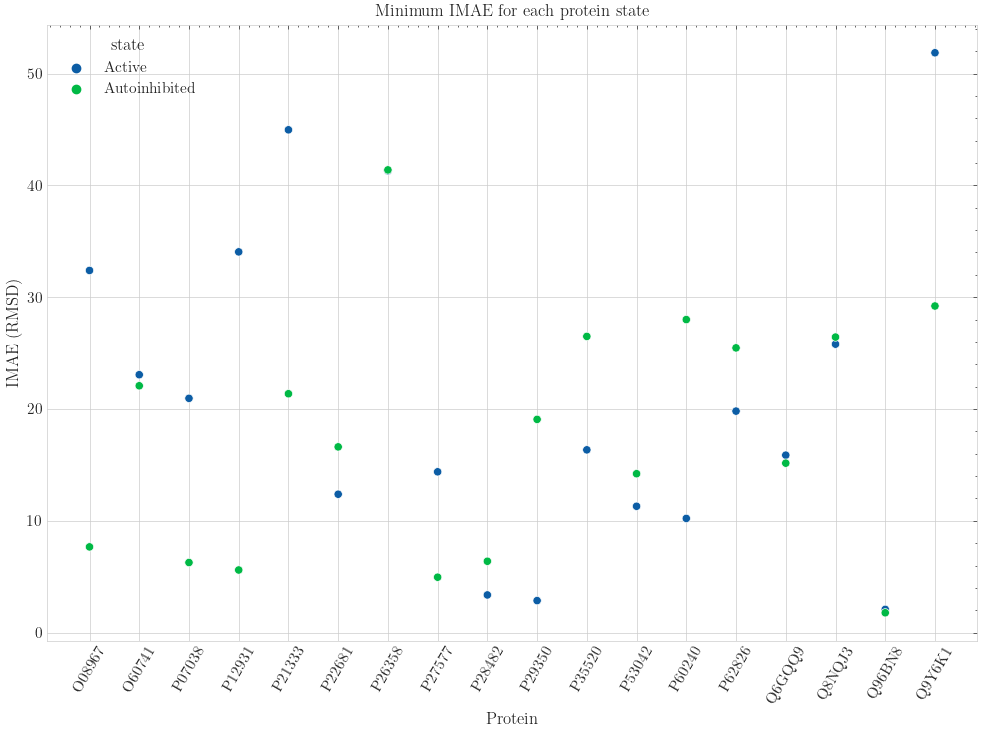

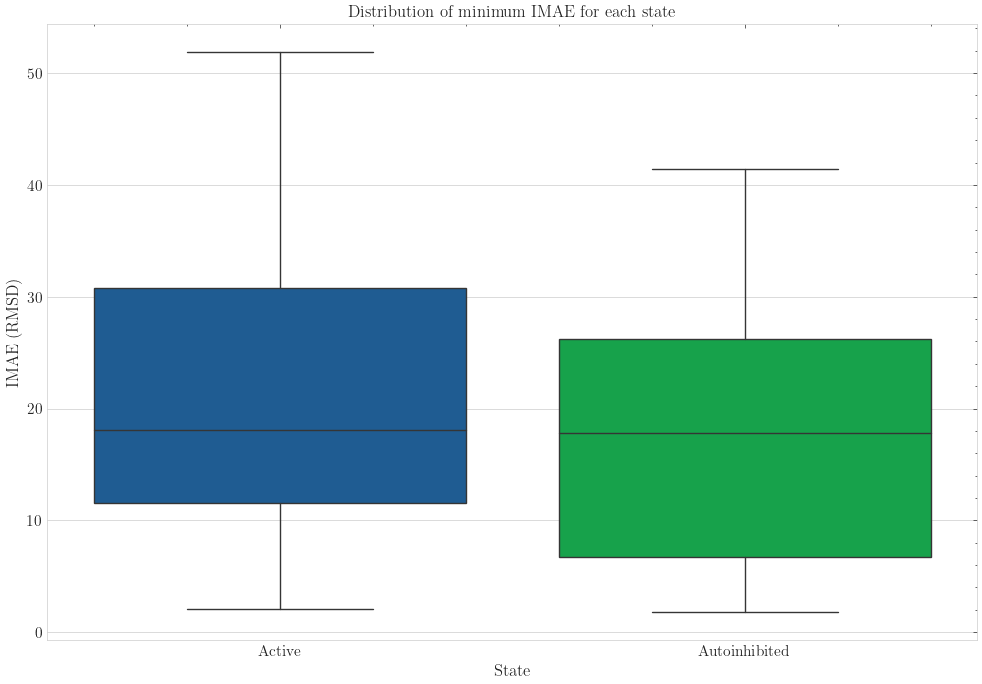

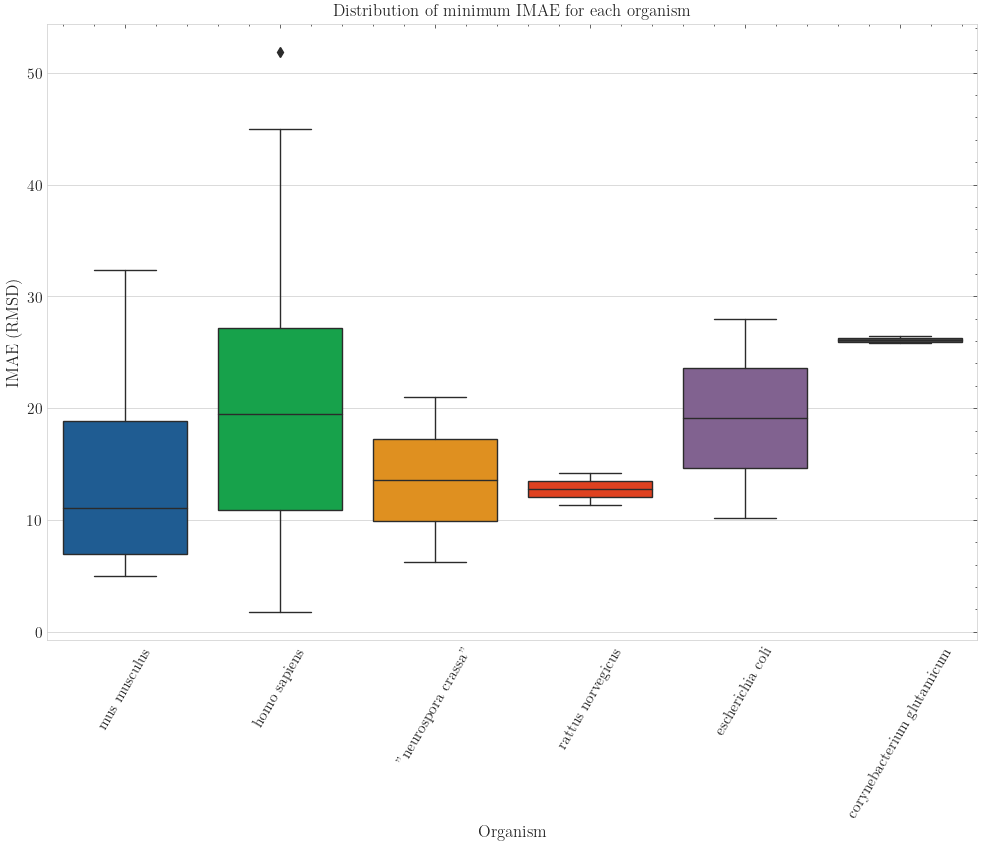

In [174]:
'''
With our dataframe corrected, we can now proceed with the analysis.
'''
plt.style.use('science')

# Drop state and conformation rows with missing values
df = df.dropna(subset=['state', 'conformation']).reset_index(drop=True)

# Convert columns to numeric
df['2_comp'] = pd.to_numeric(df['2_comp'], errors='coerce')

# Group by state and protein and find the minimum 2_comp for each group
df_min = df.groupby(['state', 'uniprot', 'pdb']).agg({'2_comp': 'min'}).reset_index()

df_clust = df[['uniprot', 'pdb', '2_comp', 'state', 'conformation', 'cluster', 'organism']]

df3 = df_min.merge(df_clust, how='left', on=['uniprot', '2_comp', 'state', 'pdb']).drop_duplicates(subset=['uniprot', 'state'], keep='first').reset_index(drop=True)

# Plot the minimum 2_comp for each state
plt.figure(figsize=(12, 8))
sns.scatterplot(x='uniprot', y='2_comp', data=df3, hue='state')
plt.title('Minimum IMAE for each protein state')
plt.xlabel('Protein')
plt.ylabel('IMAE (RMSD)')
plt.xticks(rotation=60)

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_per_state.png', format='png')

# Plot a boxplot of the distribution

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='2_comp', data=df3)
ax.set_title('Distribution of minimum IMAE for each state')
ax.set_xlabel('State')
ax.set_ylabel('IMAE (RMSD)')

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution.png', format='png')

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='organism', y='2_comp', data=df3)
ax.set_title('Distribution of minimum IMAE for each organism')
ax.set_xlabel('Organism')
ax.set_ylabel('IMAE (RMSD)')
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution_organism.png', format='png')


# medians = df3.groupby('organism')['2_comp'].median().values
# print(medians)
# nobs = df3['organism'].value_counts().values
# print(nobs)
# nobs = [str(x) for x in nobs.tolist()]
# nobs = ['n: ' + i for i in nobs]

# pos = range(len(nobs))
# for tick, label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick],
#             medians[tick] + 0.03,
#             nobs[tick],
#             horizontalalignment='center',
#             size='small',
#             color='black',
#             weight='semibold')
    

org_count = df3['organism'].value_counts()
print(org_count)

Now let's look at all ColabFold-to-PDB structure comparison.

Autoinhibited    1623
Active           1096
Name: state, dtype: int64
homo sapiens                  2554
mus musculus                    96
rattus norvegicus               24
corynebacterium glutamicum      24
"neurospora crassa"             15
escherichia coli                 6
Name: organism, dtype: int64
U10-000     239
000         233
U100-000    232
001         227
002         225
003         222
004         222
005         222
008         222
009         222
006         222
007         222
U100-001      7
010           2
Name: cluster, dtype: int64


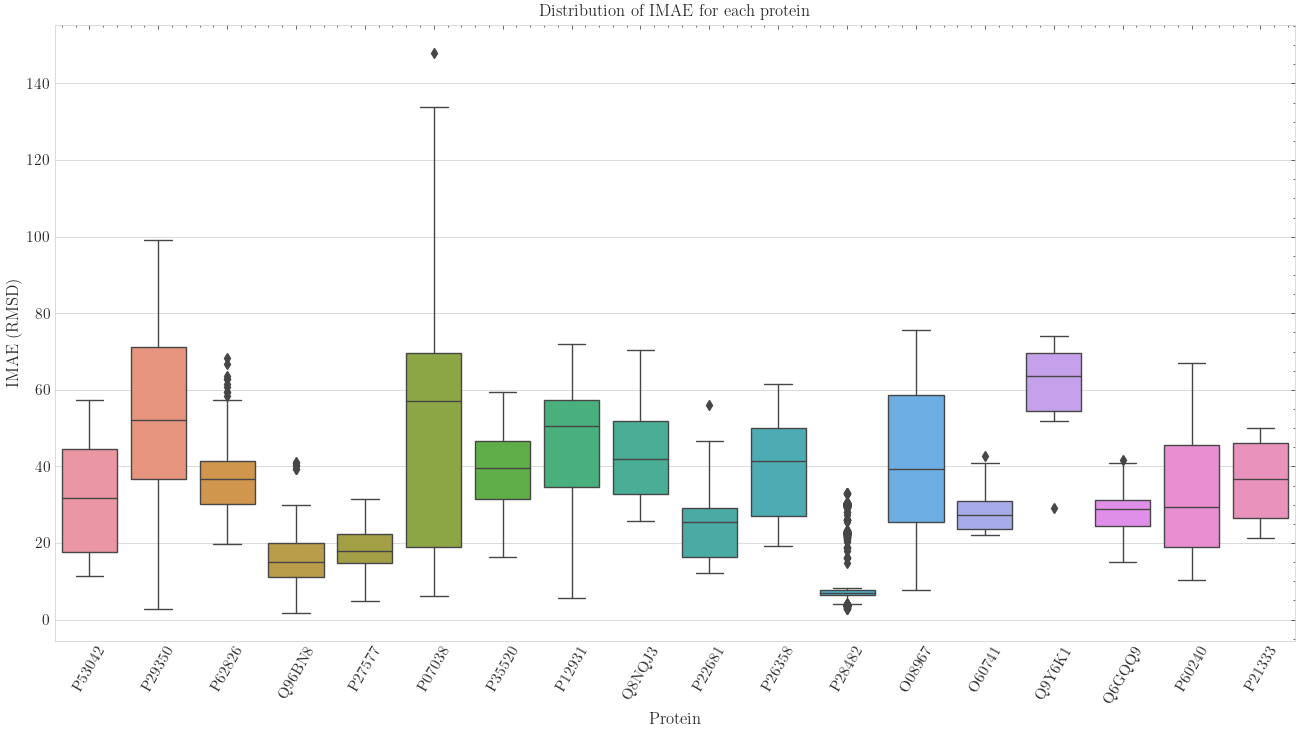

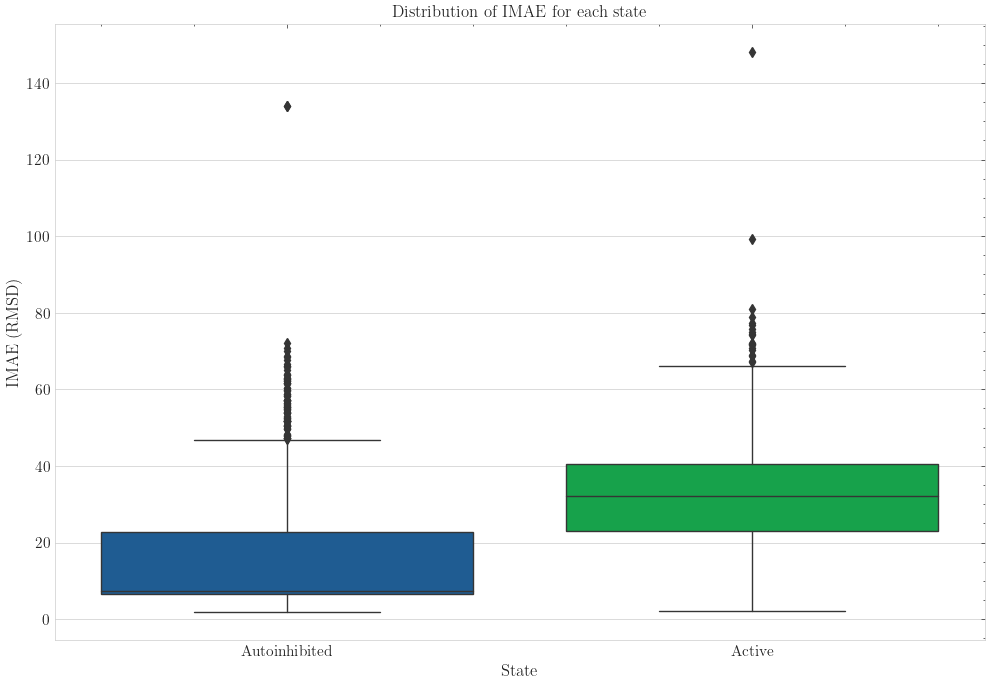

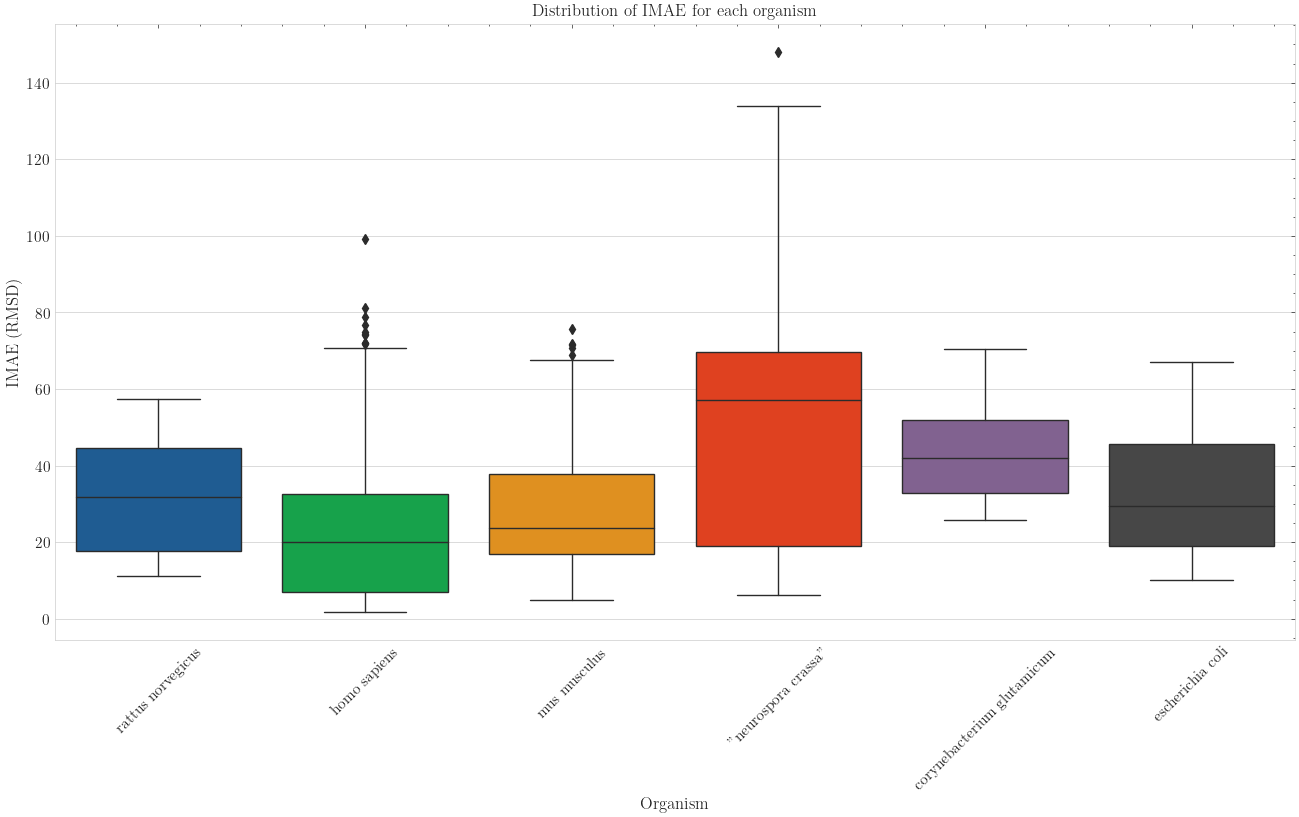

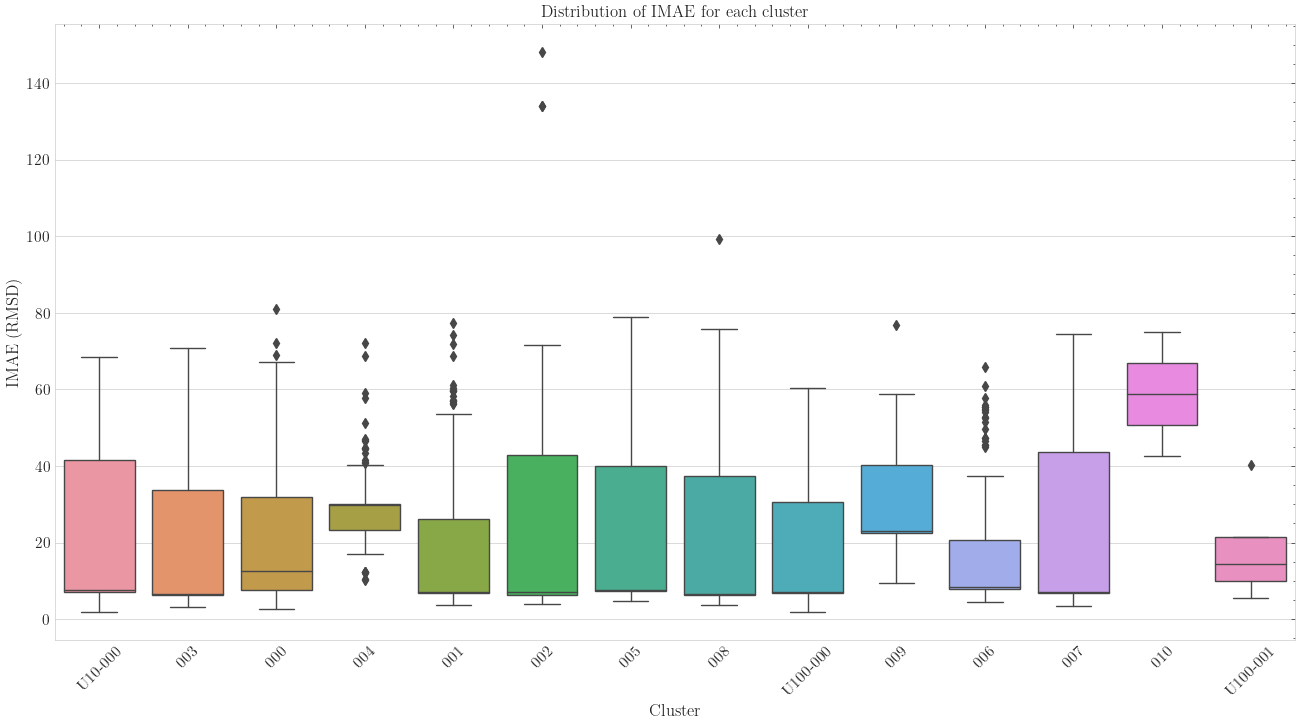

In [185]:
# Plot the distribution of minimum IMAE for each protein
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='uniprot', y='2_comp', data=df)
ax.set_title('Distribution of IMAE for each protein')
ax.set_xlabel('Protein')
ax.set_ylabel('IMAE (RMSD)')
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

plt.savefig('./project_pipeline/data/figures/cf_pdb_distribution_protein_all.png', format='png')

# Now plot the distribution of minimum IMAE for each state
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='2_comp', data=df, ax=ax1)
ax1.set_title('Distribution of IMAE for each state')
ax1.set_xlabel('State')
ax1.set_ylabel('IMAE (RMSD)')

# dfg = df.groupby('state')

# counts = [len(v) for k, v in dfg]
# total = float(sum(counts))
# cases = len(counts)

# widths = [c/total for c in counts]

# ax1.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])

plt.savefig('./project_pipeline/data/figures/cf_pdb_distribution_state_all.png', format='png')

# Do this for species as well
fig, ax2 = plt.subplots(figsize=(16, 8))
sns.boxplot(x='organism', y='2_comp', data=df)
ax2.set_title('Distribution of IMAE for each organism')
ax2.set_xlabel('Organism')
ax2.set_ylabel('IMAE (RMSD)')
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)

plt.savefig('./project_pipeline/data/figures/cf_pdb_distribution_organism_all.png', format='png')


# And clusters
fig, ax3 = plt.subplots(figsize=(16, 8))
sns.boxplot(x='cluster', y='2_comp', data=df)
ax3.set_title('Distribution of IMAE for each cluster')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('IMAE (RMSD)')
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)

plt.savefig('./project_pipeline/data/figures/cf_pdb_distribution_cluster_all.png', format='png')


# What are the counts of each?
up_count = df['uniprot'].value_counts()
state_count = df['state'].value_counts()
org_count = df['organism'].value_counts()
cluster_count = df['cluster'].value_counts()
print(state_count)
print(org_count)
print(cluster_count)

What does the cluster performance look like for the closest-fitting structures?

U100-000    19
U10-000      3
001          3
004          2
003          2
000          2
006          1
005          1
U100-001     1
002          1
009          1
Name: cluster, dtype: int64


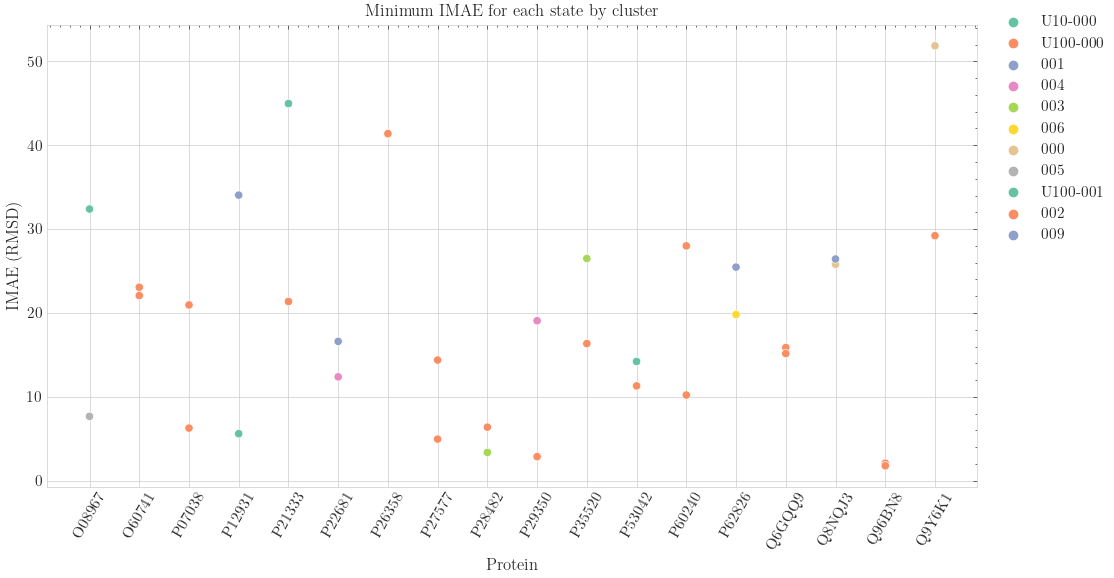

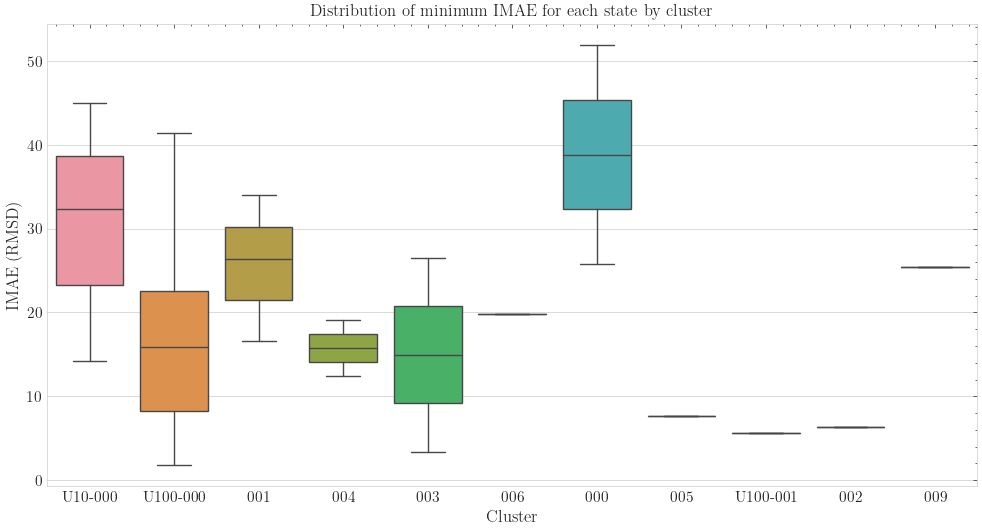

In [182]:
# Show a scatterplot by cluster
plt.style.use('science')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x='uniprot', y='2_comp', data=df3, hue='cluster', palette='Set2')
ax.set_title('Minimum IMAE for each state by cluster')
ax.set_xlabel('Protein')
ax.set_ylabel('IMAE (RMSD)')
ax.legend(bbox_to_anchor=(1.15, 1.05))
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution_cluster.png', format='png')

#Let's make a boxplot by cluster
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(x='cluster', y='2_comp', data=df3)
ax1.set_title('Distribution of minimum IMAE for each state by cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('IMAE (RMSD)')

plt.savefig('./project_pipeline/data/figures/cf_pdb_closest_structures_distribution_cluster_boxplot.png', format='png')

# medians = df3.groupby('cluster')['2_comp'].median().values
# nobs = df3['cluster'].value_counts().values
# nobs = [str(x) for x in nobs.tolist()]
# nobs = ['n: ' + i for i in nobs]

# pos = range(len(nobs))
# for tick, label in zip(pos,ax[1].get_xticklabels()):
#     ax[1].text(pos[tick],
#             medians[tick] + 0.03,
#             nobs[tick],
#             horizontalalignment='center',
#             size='small',
#             color='black',
#             weight='semibold')

cluster = df3['cluster'].value_counts()
print(cluster)